## Fit IGM nuisance parameters to eBOSS P1D, one z at a time

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time, os, sys
import matplotlib.pyplot as plt

# our own modules
import lace
from lace.archive import gadget_archive, nyx_archive
from lace.cosmo import camb_cosmo
from lace.emulator.emulator_manager import set_emulator
from cup1d.p1ds import (
    data_gadget,
    data_nyx,
    data_eBOSS_mock,
    data_Chabanier2019,
    data_Karacayli2022,
    data_Karacayli2023,
    data_Ravoux2023,
)
from cup1d.likelihood import lya_theory, likelihood, emcee_sampler
from cup1d.likelihood.sampler_pipeline import set_archive, set_P1D, set_P1D_hires, set_fid_cosmo, set_like
from cup1d.likelihood.input_pipeline import Args

# from cup1d.likelihood import lya_theory
# from cup1d.likelihood import likelihood
# from cup1d.likelihood import iminuit_minimizer

In [15]:
# set output directory for this test
output_dir = "."

# args = Args(emulator_label="Pedersen21")
args = Args(emulator_label="Pedersen23_ext8")
# args = Args(emulator_label="Cabayol23+", training_set="Cabayol23")
# args = Args(emulator_label="Nyx_alphap", training_set="Nyx23_Oct2023")
args.n_igm=1
args.fix_cosmo=True
args.n_steps=50
args.n_burn_in=10
args.parallel=False
args.explore=True
args.z_min = 2.7
args.z_max = 3.3
args.data_label = "Chabanier19"
args.data_label_hires = "Karacayli22"
args.add_hires = True
args.add_metals = True

### Set archive

In [3]:
archive = set_archive(args.training_set)

### Set emulator

In [4]:
emulator = set_emulator(
    emulator_label=args.emulator_label,
    archive=archive,
)

Use custom archive provided by the user
Select emulator in Pedersen23_ext8
Gaussian Process emulator predicting the P1D, fitting coefficients to a 5th degree polynomial. It goes to scales of 8 Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Training GP on 330 points
GPs optimised in 0.18 seconds


 /home/jchaves/miniconda3/envs/lace/lib/python3.11/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


### Set fiducial cosmology

In [5]:
cosmo_fid = set_fid_cosmo(cosmo_label=args.cosmo_label)

### Set P1D data

We create mock data starting from an mpg simulation, but we can set obs data

In [6]:
data = {"P1Ds": None, "extra_P1Ds": None}
data["P1Ds"], true_sim_igm = set_P1D(
    archive,
    emulator,
    args.data_label,
    cosmo_fid,
    cov_label=args.cov_label,
    apply_smoothing=False,
    z_min=args.z_min,
    z_max=args.z_max,
)

data["extra_P1Ds"] = set_P1D_hires(
    archive,
    emulator,
    cosmo_fid,
    args.data_label_hires,
    args.cov_label_hires,
    apply_smoothing=False,
    z_min=args.z_min,
    z_max=args.z_max,
)

 /home/jchaves/Proyectos/projects/lya/cup1d/cup1d/p1ds/base_p1d_data.py:88: UserWarning:Culling k_kms from 0.001 and 0.02 to 0.002 and 0.02


Nz = 14 , Nk = 13


 /home/jchaves/Proyectos/projects/lya/cup1d/cup1d/p1ds/base_p1d_data.py:88: UserWarning:Culling k_kms from 0.006 and 0.079 to 0.006 and 0.079


### Set likelihood

In [17]:
like = set_like(
    emulator,
    data["P1Ds"],
    data["extra_P1Ds"],
    true_sim_igm,
    args.igm_label,
    args.n_igm,
    cosmo_fid,
    fix_cosmo=args.fix_cosmo,
    add_metals=args.add_metals,
)

# this is not working yet! 
# add metal line contaminations
# free_param_names.append('ln_SiIII_0')

Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data


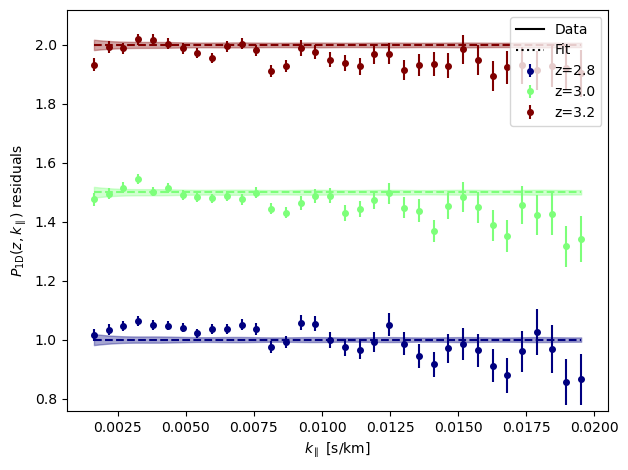

In [20]:
like.plot_p1d(residuals=True, plot_every_iz=1)

In [22]:
for p in like.free_params:
    print(p.name, p.value, p.min_value, p.max_value)

ln_tau_0 0.0 -0.4 0.4
ln_sigT_kms_0 0.0 -2.0 2.0
ln_gamma_0 0.0 -1.2 1.2
ln_kF_0 0.0 -2.0 2.0
ln_SiIII_0 -4.509860006183766 -20 0


In [23]:
def log_prob(theta):
    return log_prob.sampler.like.log_prob_and_blobs(theta)

def set_log_prob(sampler):
    log_prob.sampler = sampler
    return log_prob

sampler = emcee_sampler.EmceeSampler(
    like=like,
    rootdir=output_dir,
    save_chain=False,
    nburnin=args.n_burn_in,
    nsteps=args.n_steps,
    parallel=args.parallel,
    explore=args.explore,
    fix_cosmology=args.fix_cosmo,
)
_log_prob = set_log_prob(sampler)

Created directory: ./chain_4
setup with  1  ranks,  201  walkers, and  50  steps
combined steps  12060 (should be close to  12000 )


In [ ]:
%%time
_emcee_sam = sampler.run_sampler(log_func=_log_prob)

set 201 walkers with 5 dimensions


In [ ]:
%%time
ind = np.argmax(sampler.lnprob.reshape(-1))
nparam = sampler.chain.shape[-1]
p0 = sampler.chain.reshape(-1, nparam)[ind, :]
sampler.run_minimizer(log_func=_log_prob, p0=p0)

In [13]:
sampler.write_chain_to_file()

Can't plot IGM histories
Can't plot best fit
Can't plot corner


# OLD!!! STOP HERE

### Setup an emulator (nyx_nn, mpg_gp or mpg_nn)

In [2]:
folder_figs = os.path.abspath('.')+'/fig_fit_eBOSS_IGM/'

emulator_label="mpg_gp"
# emulator_label="mpg_nn"
# emulator_label="nyx_nn"

# add_hires=True
add_hires=False

if add_hires:
    emu_kmax_Mpc=8
    emu_ndeg=7
    flag_fig = emulator_label + '_hr'
else:
    extra_data=None
    emu_kmax_Mpc=4
    emu_ndeg=5
    flag_fig = emulator_label + '_lr'

In [3]:
if emulator_label=="mpg_gp":
    emulator=gp_emulator.GPEmulator(training_set="Pedersen21", kmax_Mpc=emu_kmax_Mpc, ndeg=emu_ndeg)
elif emulator_label=="mpg_nn":
    assert not add_hires,"NN emulator not trained beyond k=4 1/Mpc"
    emulator=nn_emulator.NNEmulator(training_set="Cabayol23", emulator_label="Cabayol23")
elif emulator_label=="nyx_nn":
    assert not add_hires,"Nyx emulator not trained beyond k=4 1/Mpc"
    emulator=nn_emulator.NNEmulator(training_set="Nyx23", emulator_label="Cabayol23_Nyx")
else:
    raise ValueError("wrong emulator_label",emulator_label)

Selected training set from Pedersen21
Selected custom emulator
Training GP on 330 points


 /home/jchaves/miniconda3/envs/py11/lib/python3.11/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.61 seconds


### Specify likelihood parameters (IGM only)

In [4]:
free_cosmo=False
if free_cosmo:
    # stick to primordial power-law parameters here
    free_param_names=["As","ns"]
else:
    free_param_names=[]
# specify the number of free parameters per IGM function (default=2)
n_igm=1
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))
# add metal line contaminations
free_param_names.append('ln_SiIII_0')

In [5]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0

### For each redshift bin / range, setup data and likelihood

In [6]:
def get_minimizer(zmin=2.7,zmax=3.3,make_plots=False):
    # set up eBOSS data
    data=data_Chabanier2019.P1D_Chabanier2019(zmin=zmin,zmax=zmax)
    if make_plots:
        data.plot_p1d()
    # Set up high-res extra data (P1D measurement from Karacayli et al. 2022)
    if add_hires:
        extra_data=data_Karacayli2022.P1D_Karacayli2022(zmin=zmin,zmax=zmax)
        if make_plots:
            extra_data.plot_p1d()
    else:
        extra_data=None
    # set up theory and likelihood
    theory=lya_theory.Theory(zs=data.z,emulator=emulator,free_param_names=free_param_names)
    like=likelihood.Likelihood(data=data,
                            theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)
    # set up minimizer and find best-fit values 
    minimizer = iminuit_minimizer.IminuitMinimizer(like)
    minimizer.minimize(compute_hesse=True)
    if make_plots:
        # get best-fit values
        best_fit_values=np.array(minimizer.minimizer.values)
        minimizer.plot_best_fit(residuals=True)
        if add_hires:
            like.extra_p1d_like.plot_p1d(values=best_fit_values,residuals=False)
    
    return minimizer

In [7]:
zlims=np.linspace(2.1,4.5,13)
Nz=len(zlims)-1
runs=[]
for iz in range(Nz):
    runs.append(get_minimizer(zmin=zlims[iz],zmax=zlims[iz+1],make_plots=False))

metal tag ln_SiIII
will not store truth, working with real data


KeyError: 0

In [ ]:
zs=[]
mF=[]
T0=[]
gamma=[]
sigT_kms=[]
kF_kms=[]
f_SiIII=[]
for run in runs:
    best_fit_values=np.array(run.minimizer.values)
    like=run.like
    z=like.data.z[0]
    print(z,'z',best_fit_values)
    zs.append(z)
    like_params=like.parameters_from_sampling_point(best_fit_values)
    F_model = like.theory.F_model_fid.get_new_model(like_params)
    T_model = like.theory.T_model_fid.get_new_model(like_params)
    P_model = like.theory.P_model_fid.get_new_model(like_params)
    X_model = like.theory.metal_models[0].get_new_model(like_params)
    mF.append(F_model.get_mean_flux(z=z))
    T0.append(T_model.get_T0(z=z))
    sigT_kms.append(T_model.get_sigT_kms(z=z))
    gamma.append(T_model.get_gamma(z=z))
    kF_kms.append(P_model.get_kF_kms(z=z))
    f_SiIII.append(X_model.get_amplitude(z=z))

In [86]:
np.savez(folder_figs + flag_fig, zs=zs, 
         mF=mF, T0=T0, gamma=gamma, 
         sigT_kms=sigT_kms, kF_kms=kF_kms, f_SiIII=f_SiIII)

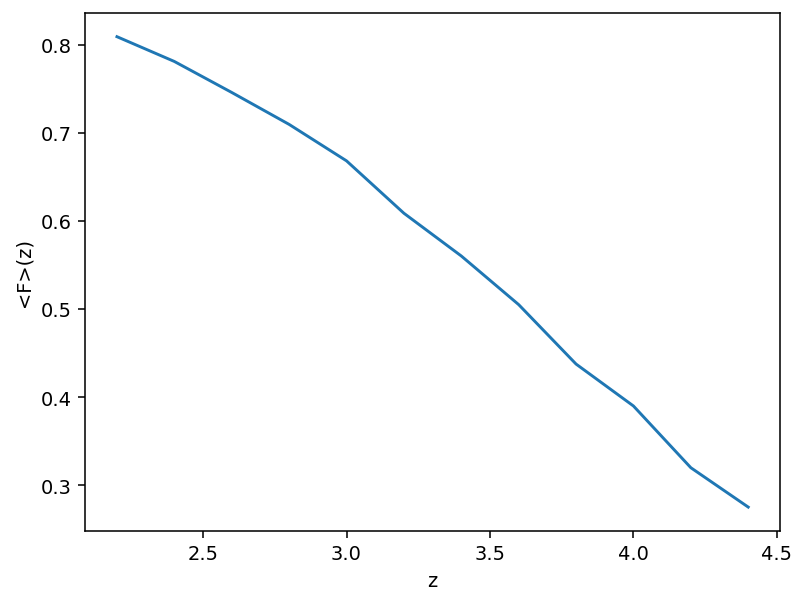

In [87]:
plt.plot(zs,mF)
plt.xlabel('z')
plt.ylabel('<F>(z)')
plt.savefig(folder_figs + flag_fig+'_mF.png')

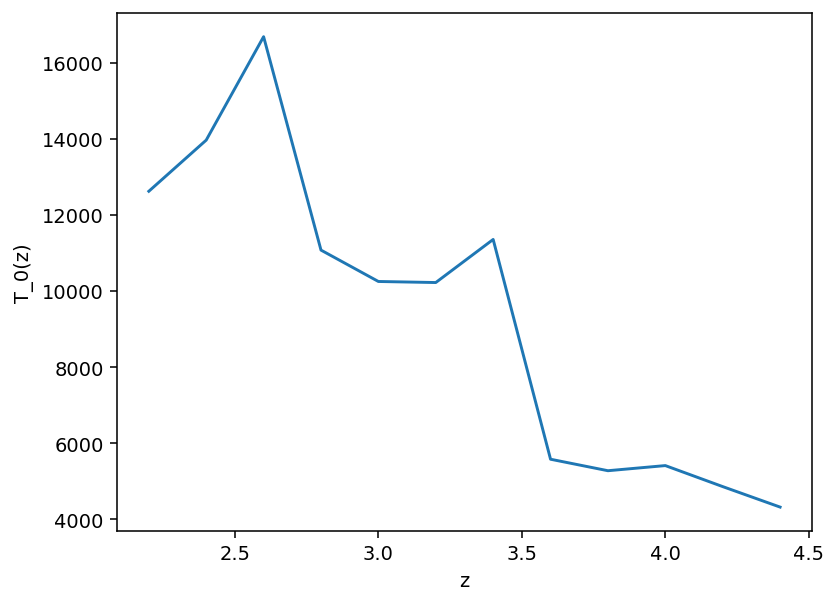

In [88]:
plt.plot(zs,T0)
plt.xlabel('z')
plt.ylabel('T_0(z)')
plt.savefig(folder_figs + flag_fig+'_T0.png')

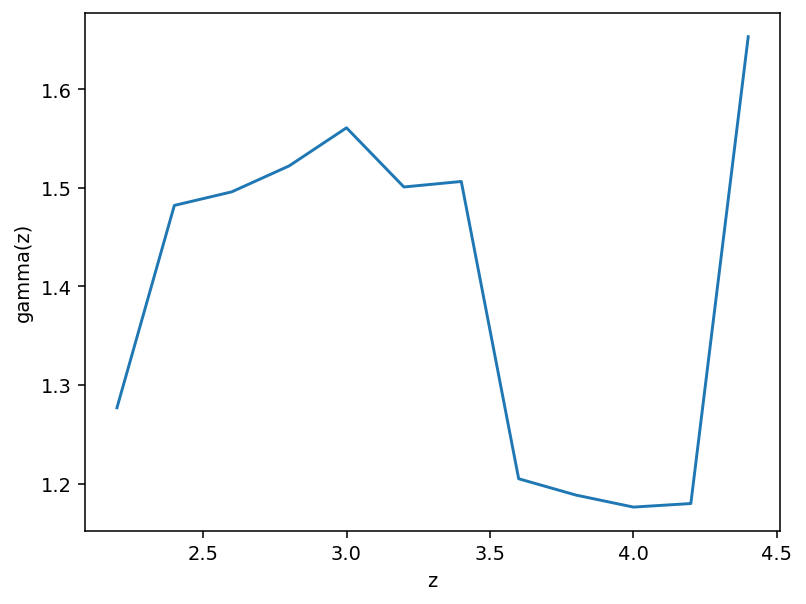

In [89]:
plt.plot(zs,gamma)
plt.xlabel('z')
plt.ylabel('gamma(z)')
plt.savefig(folder_figs + flag_fig+'_gamma.png')

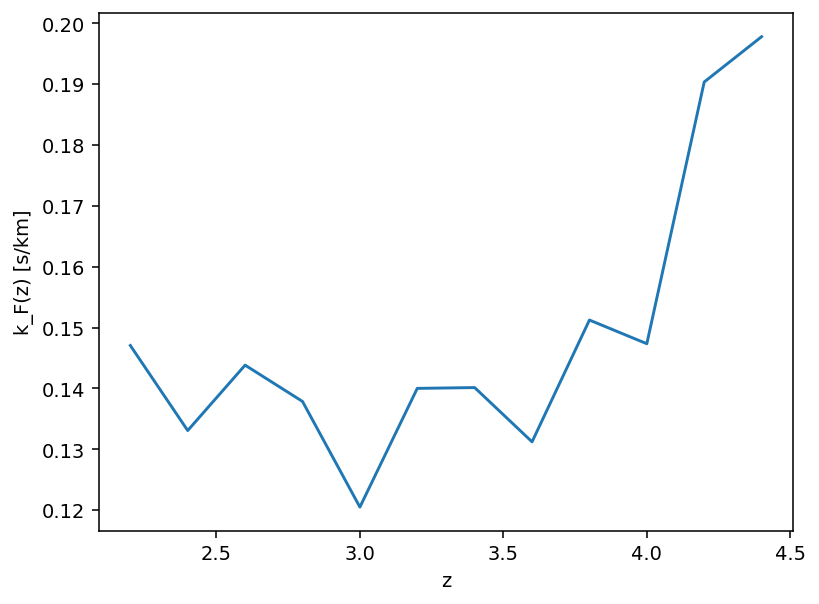

In [90]:
plt.plot(zs,kF_kms)
plt.xlabel('z')
plt.ylabel('k_F(z) [s/km]')
plt.savefig(folder_figs + flag_fig+'_kF.png')

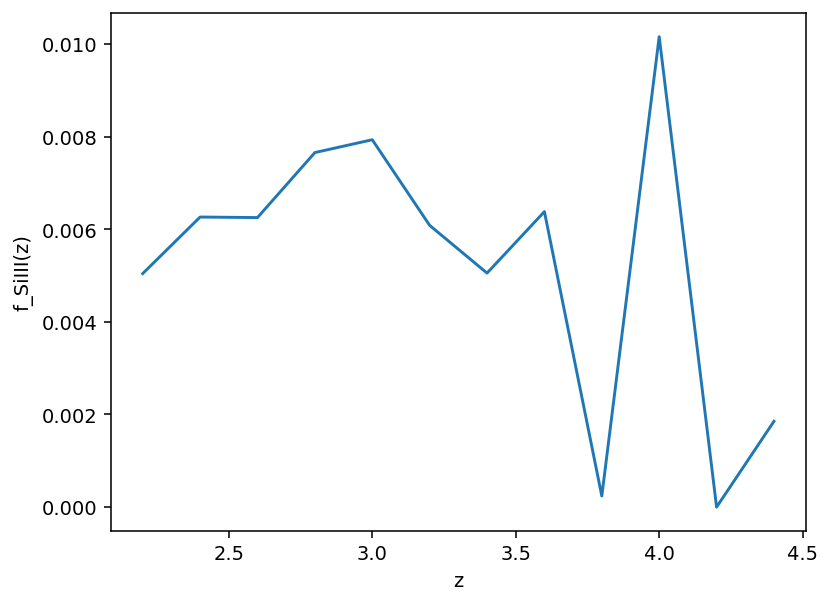

In [91]:
plt.plot(zs,f_SiIII)
plt.xlabel('z')
plt.ylabel('f_SiIII(z)')
plt.savefig(folder_figs + flag_fig+'_SiIII.png')

### Plots for all options

In [92]:
folder_figs = os.path.abspath('.')+'/fig_fit_eBOSS_IGM/'

emulator_label = ["mpg_gp_hr", "mpg_gp_lr", "mpg_nn_lr", "nyx_nn_lr"]

dat = []
for lab in emulator_label:
    dat.append(np.load(folder_figs + lab + '.npz'))

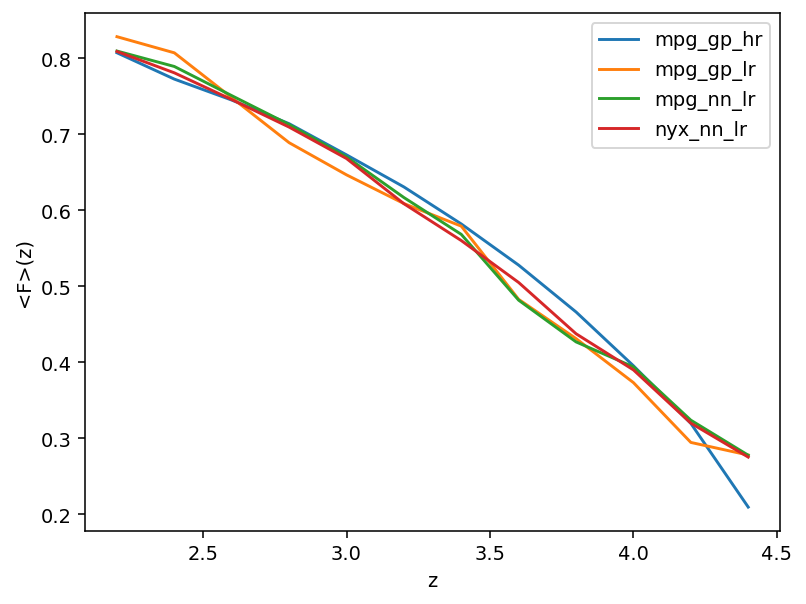

In [94]:
for ii, lab in enumerate(emulator_label):
    plt.plot(dat[ii]["zs"], dat[ii]["mF"], label=lab)
    
plt.xlabel('z')
plt.ylabel('<F>(z)')
plt.legend()
plt.savefig(folder_figs + '/mF.png')

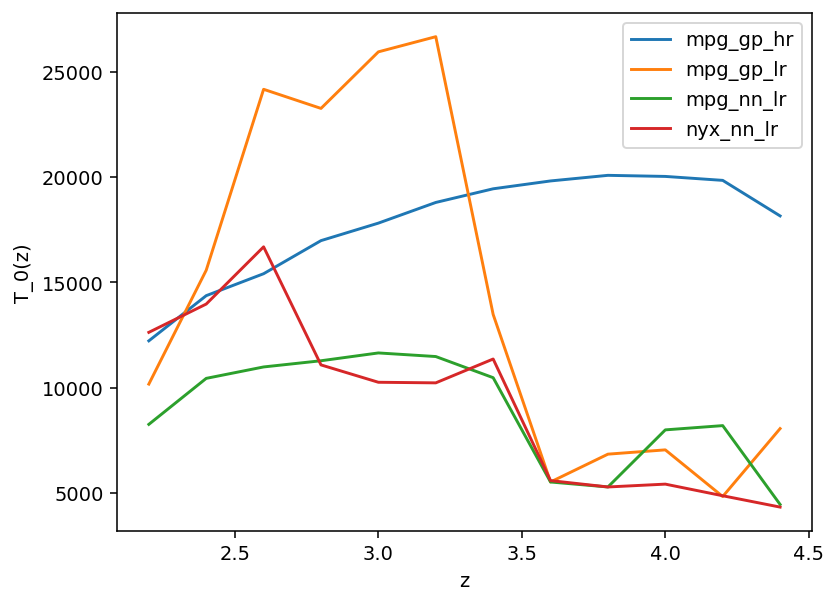

In [96]:
for ii, lab in enumerate(emulator_label):
    plt.plot(dat[ii]["zs"], dat[ii]["T0"], label=lab)
    
plt.xlabel('z')
plt.ylabel('T_0(z)')
plt.legend()
plt.savefig(folder_figs + '/T0.png')

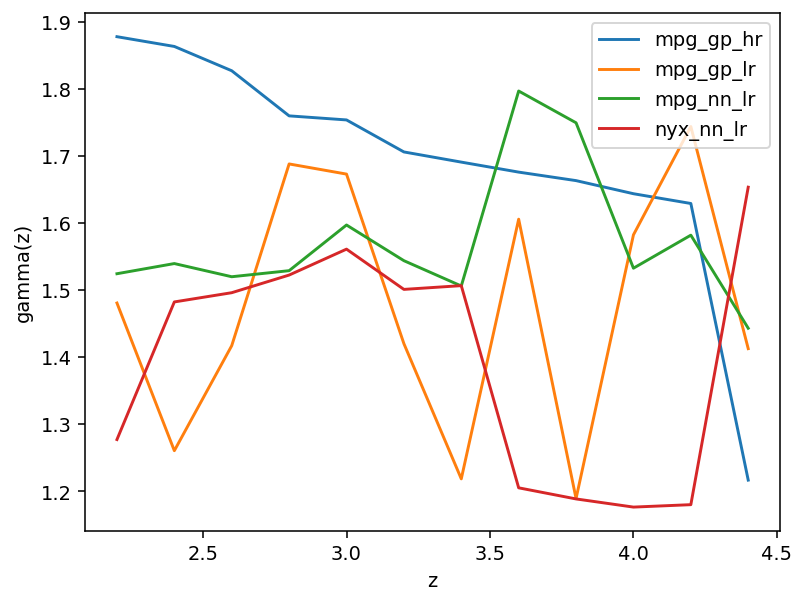

In [97]:
for ii, lab in enumerate(emulator_label):
    plt.plot(dat[ii]["zs"], dat[ii]["gamma"], label=lab)
    
plt.xlabel('z')
plt.ylabel('gamma(z)')
plt.legend()
plt.savefig(folder_figs + '/gamma.png')


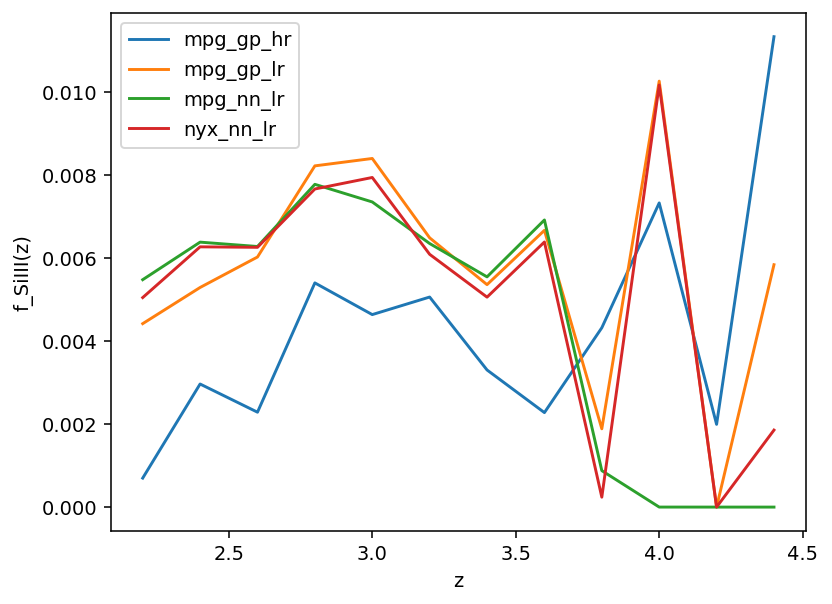

In [102]:
for ii, lab in enumerate(emulator_label):
    plt.plot(dat[ii]["zs"], dat[ii]["f_SiIII"], label=lab)
    
plt.xlabel('z')
plt.ylabel('f_SiIII(z)')
plt.legend()
plt.savefig(folder_figs + '/SiIII.png')
